In [1]:
import numpy as np
import pandas as pd
# import shap
import yaml
import xgboost
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# +-----------------------------------------------------------------------------

# from workers.flow import (Node, CreditFlow, Graph, get_source_nodes,
#                           topo_sort, flatten_graph, eval_graph,
#                           boundary_graph, single_source_graph,
#                           viz_graph, save_graph, hcluster_graph)
from flow import ParallelCreditFlow, GraphExplainer, translator
from flow import group_nodes, build_feature_graph
from flow import CausalLinks, create_xgboost_f, create_linear_f
from flow import edge_credits2edge_credit, node_dict2str_dict
# from workers.on_manifold import (OnManifoldExplainer, IndExplainer, FeatureAttribution)
# from workers.linear_evaluation import (get_error, get_indirect_effect_flow,
#     get_effect_asv, get_effect_ind, get_effect_manifold, get_direct_effect_flow)
# from workers.linear_evaluation import get_direct_effect_ground_truth, get_indirect_effect_ground_truth

# +-----------------------------------------------------------------------------

from hyperopt import hp, tpe, space_eval, STATUS_OK, Trials
from hyperopt.fmin import fmin

warnings.filterwarnings('ignore')

In [2]:
# +-----------------------------------------------------------------------------
# Загрузка параметров вручную, т.к. у меня эта была другая "тестовая" среда

with open('./config/config.yaml', 'rb') as f:
    cfg = yaml.safe_load(f.read())

X = pd.read_pickle(cfg['PATH_TO_X'])
Y = pd.read_pickle(cfg['PATH_TO_Y'])
RS = cfg['RANDOM_STATE']
OPTUNA_TRIAL_NUMBER = cfg['OPTUNA_TRIAL_NUMBER']
STRATIFY = cfg['STRATIFY']
CLASS_WEIGHT = dict(cfg['CLASS_WEIGHT'])
N_PREDICTORS = cfg['N_PREDICTORS']
BALANCED = cfg['BALANCED']
PATH_TO_OUTPUT = cfg['PATH_TO_OUTPUT']
PATH_TO_PLOT = cfg['PATH_TO_PLOT']
SCORER = cfg['SCORER']
TEST_SIZE = cfg['TEST_SIZE']

# Наши предикторы:

PREDICTORS = [
    'Время ИК',
    'Hb до операции',
    'ИМТ',
    'КДР(исх)',
    'ФК аортального клапана',
    'НРС д/о  (1-есть,0-нет)',
    'Пиковый градиент на АК д/о',
    'Стеноз -1, недостаточность-0',
    'Время пережатия аорты',
    'POAF',
    'ИБС (Да/Нет - 1/0)',
    'Возраст, лет',
    'Перенесенный ИМ (Да/Нет - 1/0)',
    'ФП д/о',
    'ППС Порок МК (Да/Нет - 1/0)'
]

In [3]:
# +-----------------------------------------------------------------------------
# Вспоминаем, кто из переменных - категориальные  и делаем список с
# вещественными переменными

cat_lst = [x for x in X[PREDICTORS].columns if
           pd.CategoricalDtype.is_dtype(X[x]) == True]
sc_lst = [col for col in X[PREDICTORS].columns if col not in cat_lst]

# Преобразуем бинарные переменные в целые
X.loc[:, cat_lst] = X[cat_lst].astype(int)

# # Проеобразуем категориальные переменные к категориальному виду в DataFrame
# X[cat_lst] = X[cat_lst].astype("category")

# Стратифицированный сплит

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X[PREDICTORS],
                                                    Y,
                                                    X[PREDICTORS].index,
                                                    test_size=TEST_SIZE,
                                                    random_state=RS,
                                                    stratify=Y)

# +-----------------------------------------------------------------------------
# Нормализуем вещественные переменные

sc = StandardScaler()

X_train[sc_lst] = sc.fit_transform(X_train[sc_lst])
X_test[sc_lst] = sc.transform(X_test[sc_lst])

# # +-----------------------------------------------------------------------------
# # У меня не получилось ни обозначить категориальные переменные в XGB,
# # ни заставить это работать через логистическую регрессию также с обозначение
# # категориальных переменных. Везде 0 получаются. Как-то работает через модель
# # LinearRegression
# # Т.е., основная цель предыдущего шага с нормализацией в таком контексте -
# # оставить нетронутыми (ненормализованными) бинарные переменные
#
# for col in X_train.columns:
#     X_train[col] = X_train[col].astype(float)
#
# for col in X_train.columns:
#     X_test[col] = X_test[col].astype(float)

# +-----------------------------------------------------------------------------
# Создание модели из xgboost

xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

# params = {
#     "tree_method": "hist",
#     "eta": 0.01,
#     "max_depth": 15,
#     'objective': 'binary:logistic'
# }
#
# model = LinearRegression().fit(X_train, y_train)

# params = {
#     "eta": 0.01,
#     "max_depth": 7,
#     'eval_metric': 'auc',
#     'objective':'binary:logistic', # output probability
#     "subsample": 0.9
# }
params = {'learning_rate': 0.03942389417714505,
 'max_depth': 1,
 'n_estimators': 1104,
 'subsample': 0.4258489088180469,
          'scale_pos_weight': X_train.loc[y_train[y_train==0].index, :].shape[0]/X_train.loc[y_train[y_train==1].index, :].shape[0],
              'eval_metric': 'auc',
          'early_stopping_rounds': 20,
    'objective':'binary:logistic', # output probability
}

n_samples = 20
# model = xgboost.XGBClassifier(**params)
# eval_set = [(X_train, y_train), (X_test, y_test)]
# model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

model = xgboost.train(params=params,
                      dtrain=xgb_train,
                      num_boost_round=3000,
                      evals = [(xgb_test, "test")],
                      early_stopping_rounds=100,
                      verbose_eval=1000)

bg = X_test.loc[y_test[y_test==0].index, :]
fg = X_test.loc[y_test[y_test==1].index, :]

# # +-----------------------------------------------------------------------------
# # # Создание f-функции
#
# f = lambda x: model.predict(xgboost.DMatrix(pd.DataFrame(x,
#                                                          columns=feature_names)), output_margin=True)

[16:46:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1662013930492/work/src/learner.cc:627: 
Parameters: { "early_stopping_rounds", "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	test-auc:0.74130
[110]	test-auc:0.81304


In [4]:
model.best_score

0.8406521739130435

## Тюнинг параметров

In [8]:
def optimal_xgboost(xgb_train, xgb_test):
    """
    Находит оптимальные параметры XGB
    """
    def objective(params):
        # Параметры, которые будем подбирать
        var_params = {
            'learning_rate': params['learning_rate'],
            'n_estimators': int(params['n_estimators']),
            'max_depth': int(params['max_depth']),
            'subsample': params['subsample']
                 }

        # Параметры, которые не будем менять
        const_params = {'objective':'binary:logistic', # output probability
                'scale_pos_weight': X_train.loc[y_train[y_train==0].index, :].shape[0]/X_train.loc[y_train[y_train==1].index, :].shape[0],
                'eval_metric': 'auc',
                'early_stopping_rounds': 20,
                'verbosity': 0,
                'random_state': RS
               }

        model = xgboost.XGBClassifier(**const_params, **var_params)
        eval_set = [(X_train, y_train), (X_test, y_test)]
        model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

        # model = xgboost.train(params={**const_params, **var_params},
        #               dtrain=xgb_train,
        #               num_boost_round=3000,
        #               evals = [(xgb_test, "test")])

        loss = 1 - model.best_score

        return {'loss': loss,
                'status': STATUS_OK
               }

    space = {
        'learning_rate':    hp.uniform('learning_rate', 0.001, 0.05),
        'max_depth':        hp.choice('max_depth', range(2, 10)),
        'n_estimators':        hp.choice('n_estimators', range(100, 3000)),
        'subsample':        hp.uniform('subsample', 0.3, 1),
    }


    trials = Trials()

    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=200,
               trials=trials)
    return best

In [9]:
optimal_xgboost(xgb_train, xgb_test)

100%|██████████| 200/200 [01:00<00:00,  3.28trial/s, best loss: 0.11782608695652175]


{'learning_rate': 0.03942389417714505,
 'max_depth': 1,
 'n_estimators': 1104,
 'subsample': 0.4258489088180469}

In [17]:
model.best_score

0.8406521739130435

learning dependency for POAF:   0%|          | 0/10 [00:00<?, ?it/s]

[0]	test-mlogloss:0.69225
[100]	test-mlogloss:0.61095
[200]	test-mlogloss:0.55396
[300]	test-mlogloss:0.51223
[400]	test-mlogloss:0.48158
[499]	test-mlogloss:0.45880


learning dependency for ФК аортального клапана:  10%|█         | 1/10 [00:01<00:09,  1.09s/it]

[0]	test-rmse:1.06549
[100]	test-rmse:0.98633
[200]	test-rmse:0.92764
[300]	test-rmse:0.88427
[400]	test-rmse:0.85292
[499]	test-rmse:0.83120


learning dependency for ППС Порок МК (Да/Нет - 1/0):  20%|██        | 2/10 [00:01<00:05,  1.40it/s]

[0]	test-mlogloss:0.69185
[100]	test-mlogloss:0.58110
[200]	test-mlogloss:0.50372
[300]	test-mlogloss:0.44878
[400]	test-mlogloss:0.40898
[499]	test-mlogloss:0.38070


learning dependency for Время ИК:  30%|███       | 3/10 [00:02<00:04,  1.61it/s]                   

[0]	test-rmse:1.27781
[100]	test-rmse:1.24997
[200]	test-rmse:1.23313
[300]	test-rmse:1.22223
[400]	test-rmse:1.21703
[499]	test-rmse:1.21453


learning dependency for Перенесенный ИМ (Да/Нет - 1/0):  40%|████      | 4/10 [00:02<00:03,  1.71it/s]

[0]	test-mlogloss:0.69162
[100]	test-mlogloss:0.55990
[200]	test-mlogloss:0.46515
[300]	test-mlogloss:0.39529
[400]	test-mlogloss:0.34224
[499]	test-mlogloss:0.30208


learning dependency for НРС д/о  (1-есть,0-нет):  50%|█████     | 5/10 [00:03<00:02,  1.80it/s]       

[0]	test-mlogloss:0.69279
[100]	test-mlogloss:0.66249
[200]	test-mlogloss:0.64228
[300]	test-mlogloss:0.62930
[400]	test-mlogloss:0.62150
[499]	test-mlogloss:0.61696


learning dependency for ФП д/о:  60%|██████    | 6/10 [00:03<00:02,  1.73it/s]                 

[0]	test-mlogloss:0.69184
[100]	test-mlogloss:0.58720
[200]	test-mlogloss:0.51389
[300]	test-mlogloss:0.46028
[400]	test-mlogloss:0.42139
[499]	test-mlogloss:0.39258


learning dependency for Время пережатия аорты:  70%|███████   | 7/10 [00:04<00:01,  1.55it/s]

[0]	test-rmse:1.06394
[100]	test-rmse:0.96309
[200]	test-rmse:0.88954
[300]	test-rmse:0.84203
[400]	test-rmse:0.81211
[499]	test-rmse:0.79302


learning dependency for КДР(исх):  80%|████████  | 8/10 [00:04<00:01,  1.68it/s]             

[0]	test-rmse:1.15038
[100]	test-rmse:1.11367
[200]	test-rmse:1.08854
[300]	test-rmse:1.07017
[400]	test-rmse:1.05749
[499]	test-rmse:1.05008


learning dependency for Пиковый градиент на АК д/о:  90%|█████████ | 9/10 [00:05<00:00,  1.74it/s]

[0]	test-rmse:1.18016
[100]	test-rmse:1.04514
[200]	test-rmse:0.94294
[300]	test-rmse:0.86748
[400]	test-rmse:0.81279
[499]	test-rmse:0.77365


learning dependency for Пиковый градиент на АК д/о: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]


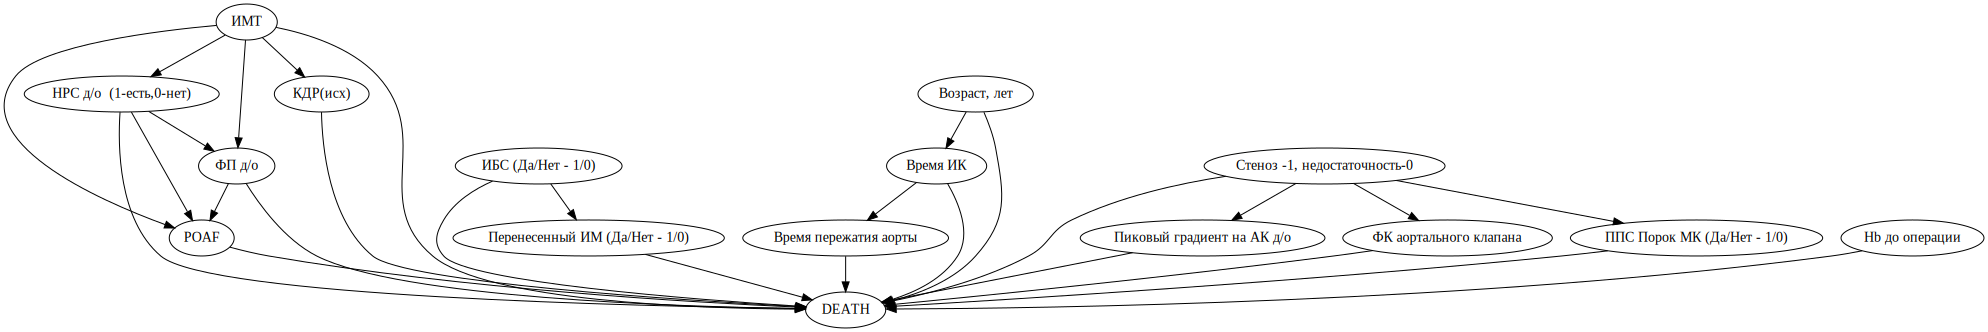

In [5]:
# Создание графа

causal_links = CausalLinks()
target_name = 'DEATH'
feature_names = PREDICTORS

# Ребра учета непосредственного влияния фичей на результат
causal_links.add_causes_effects(feature_names, target_name,
                                create_xgboost_f(feature_names, model, output_margin=True))
# Ребра влияния одних фичей на другие
causal_links.add_causes_effects('Время ИК', 'Время пережатия аорты')
causal_links.add_causes_effects('ИМТ', 'НРС д/о  (1-есть,0-нет)')
causal_links.add_causes_effects('ИМТ', 'ФП д/о')
causal_links.add_causes_effects('ИМТ', 'POAF')
causal_links.add_causes_effects('ИМТ', 'КДР(исх)')
causal_links.add_causes_effects('ИБС (Да/Нет - 1/0)',
                                'Перенесенный ИМ (Да/Нет - 1/0)')
causal_links.add_causes_effects('Стеноз -1, недостаточность-0',
                                'ФК аортального клапана')
causal_links.add_causes_effects('Стеноз -1, недостаточность-0',
                                'Пиковый градиент на АК д/о')
causal_links.add_causes_effects('Стеноз -1, недостаточность-0',
                                'ППС Порок МК (Да/Нет - 1/0)')
causal_links.add_causes_effects('ФП д/о', 'POAF')
causal_links.add_causes_effects('НРС д/о  (1-есть,0-нет)', 'ФП д/о')
causal_links.add_causes_effects('НРС д/о  (1-есть,0-нет)', 'POAF')
causal_links.add_causes_effects('Возраст, лет', 'Время ИК')
causal_links.add_causes_effects('ИМТ', 'КДР(исх)')
causal_graph = build_feature_graph(X=X_train,
                                   causal_links=causal_links,
                                   categorical_feature_names=cat_lst,
                                   target_name=target_name,
                                   method="xgboost")

causal_graph.draw(rankdir="TB", save_fpath='causal_graph.png')


In [6]:
# Создание эксплейнера. Во всех примерах со всеми классами (GraphExplainer, 
# on_manifold и т.д.) требуется параметр `sample_ind`, обозначающий отдельное 
# наблюдение/пациента. Для каждого пациента рассматривать эти графы бессмысленно. 
# Ниже я демонстрирую, что будет, если в список `sample_ind` загрузить несколько 
# пациенртов. Теоретически, зависимости меняются и SHAP values становятся ВСЕ 
# синие. 

# G = GraphExplainer(causal_graph, bg, nruns=100)
# cf_flow_adult = G.shap_values(fg)
# sample_ind = [6]
#
# cf_flow_adult.draw(max_display=len(PREDICTORS))

# multiple background result
edge_credits = [] # save for each run
for i in range(len(bg)): # average run result using linearity axiom
    print(f'bg {i}/{len(bg)}')
    explainer = GraphExplainer(causal_graph, bg[i:i+1], nruns=1)
    cf = explainer.shap_values(fg)
    edge_credits.append(node_dict2str_dict(cf.edge_credit)) # use node name is more portable vs. node


bg 0/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


bg 1/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


bg 2/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


bg 3/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


bg 4/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


bg 5/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


bg 6/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


bg 7/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


bg 8/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


bg 9/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


bg 10/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


bg 11/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


bg 12/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


bg 13/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


bg 14/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


bg 15/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


bg 16/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


bg 17/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


bg 18/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


bg 19/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


bg 20/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


bg 21/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


bg 22/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


bg 23/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


bg 24/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


bg 25/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


bg 26/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


bg 27/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


bg 28/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


bg 29/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


bg 30/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


bg 31/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


bg 32/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


bg 33/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


bg 34/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


bg 35/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


bg 36/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


bg 37/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


bg 38/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


bg 39/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


bg 40/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


bg 41/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


bg 42/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


bg 43/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


bg 44/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


bg 45/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


bg 46/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


bg 47/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


bg 48/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


bg 49/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


bg 50/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


bg 51/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


bg 52/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


bg 53/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


bg 54/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


bg 55/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


bg 56/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


bg 57/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


bg 58/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


bg 59/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


bg 60/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


bg 61/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


bg 62/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


bg 63/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


bg 64/230


bruteforce sampling: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


bg 65/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


bg 66/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


bg 67/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


bg 68/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


bg 69/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


bg 70/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


bg 71/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


bg 72/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


bg 73/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


bg 74/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


bg 75/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


bg 76/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


bg 77/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


bg 78/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


bg 79/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


bg 80/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


bg 81/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


bg 82/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


bg 83/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


bg 84/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


bg 85/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


bg 86/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


bg 87/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


bg 88/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


bg 89/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


bg 90/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


bg 91/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


bg 92/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


bg 93/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


bg 94/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


bg 95/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


bg 96/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


bg 97/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


bg 98/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


bg 99/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


bg 100/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


bg 101/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


bg 102/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


bg 103/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


bg 104/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


bg 105/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


bg 106/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


bg 107/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


bg 108/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


bg 109/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


bg 110/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


bg 111/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


bg 112/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


bg 113/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


bg 114/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


bg 115/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


bg 116/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


bg 117/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


bg 118/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


bg 119/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


bg 120/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


bg 121/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


bg 122/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


bg 123/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


bg 124/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


bg 125/230


bruteforce sampling: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


bg 126/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


bg 127/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


bg 128/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


bg 129/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


bg 130/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


bg 131/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


bg 132/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


bg 133/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


bg 134/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


bg 135/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


bg 136/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


bg 137/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


bg 138/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


bg 139/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


bg 140/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


bg 141/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


bg 142/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


bg 143/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


bg 144/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


bg 145/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


bg 146/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


bg 147/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


bg 148/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


bg 149/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


bg 150/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


bg 151/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


bg 152/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


bg 153/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


bg 154/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


bg 155/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


bg 156/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


bg 157/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


bg 158/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


bg 159/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


bg 160/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


bg 161/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


bg 162/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


bg 163/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


bg 164/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


bg 165/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


bg 166/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


bg 167/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


bg 168/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


bg 169/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


bg 170/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


bg 171/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


bg 172/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


bg 173/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


bg 174/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


bg 175/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


bg 176/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


bg 177/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


bg 178/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


bg 179/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


bg 180/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


bg 181/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


bg 182/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


bg 183/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


bg 184/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


bg 185/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


bg 186/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


bg 187/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


bg 188/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


bg 189/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


bg 190/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


bg 191/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


bg 192/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


bg 193/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


bg 194/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


bg 195/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


bg 196/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


bg 197/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


bg 198/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


bg 199/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


bg 200/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


bg 201/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


bg 202/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


bg 203/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


bg 204/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


bg 205/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


bg 206/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


bg 207/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


bg 208/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


bg 209/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


bg 210/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


bg 211/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


bg 212/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


bg 213/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


bg 214/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


bg 215/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


bg 216/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


bg 217/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


bg 218/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


bg 219/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


bg 220/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


bg 221/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


bg 222/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


bg 223/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


bg 224/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


bg 225/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


bg 226/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


bg 227/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


bg 228/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


bg 229/230


bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


bruteforce sampling: 100%|██████████| 100/100 [00:21<00:00,  4.64it/s]


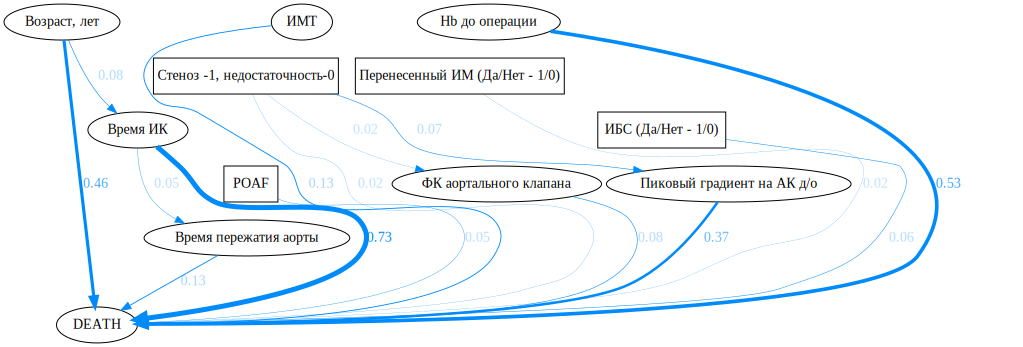

In [14]:
G = GraphExplainer(causal_graph, bg, nruns=100)
cf_flow_adult = G.shap_values(fg)
cf_flow_adult.draw(-1,
                   max_display=len(PREDICTORS),
                   #edge_credit=edge_credits2edge_credit(edge_credits, cf_flow_adult.graph),
                   show_fg_val=True,
                   save_fpath='mean_graph.png')


0it [00:00, ?it/s]


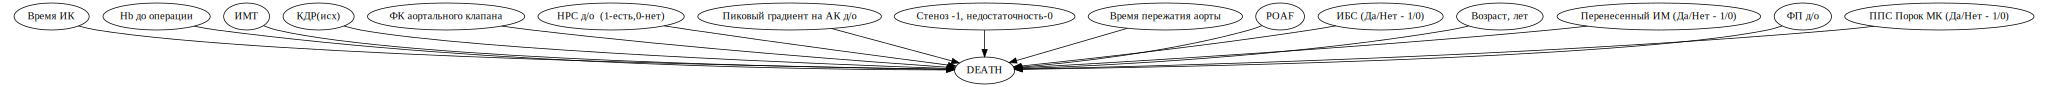

In [15]:
# Создание графа с независимыми признаками

causal_links_ind = CausalLinks()
target_name = 'DEATH'
feature_names = PREDICTORS

# Ребра учета непосредственного влияния фичей на результат
causal_links_ind.add_causes_effects(feature_names, target_name,
                                create_xgboost_f(feature_names, model, output_margin=True))

causal_graph_ind = build_feature_graph(X=X_train,
                                   causal_links=causal_links_ind,
                                   categorical_feature_names=cat_lst,
                                   target_name=target_name,
                                   method="xgboost")

causal_graph_ind.draw(rankdir="TB", save_fpath='causal_graph_ind.png')


bruteforce sampling: 100%|██████████| 100/100 [00:04<00:00, 23.76it/s]


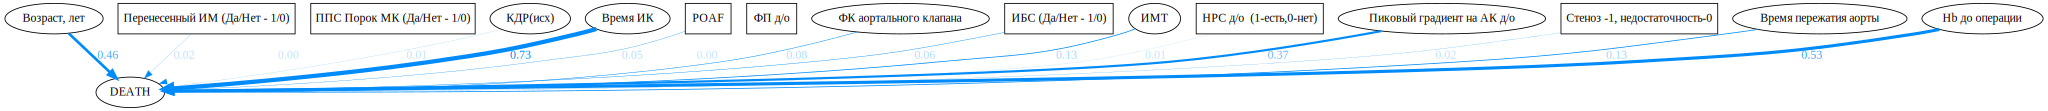

In [16]:
G_ind = GraphExplainer(causal_graph_ind, bg, nruns=100)
cf_flow_adult_ind = G_ind.shap_values(fg)
cf_flow_adult_ind.draw(-1,
                   max_display=len(PREDICTORS),
                   #edge_credit=edge_credits2edge_credit(edge_credits, cf_flow_adult.graph),
                   show_fg_val=True,
                   save_fpath='mean_graph_ind.png')

bruteforce sampling: 100%|██████████| 100/100 [00:24<00:00,  4.02it/s]


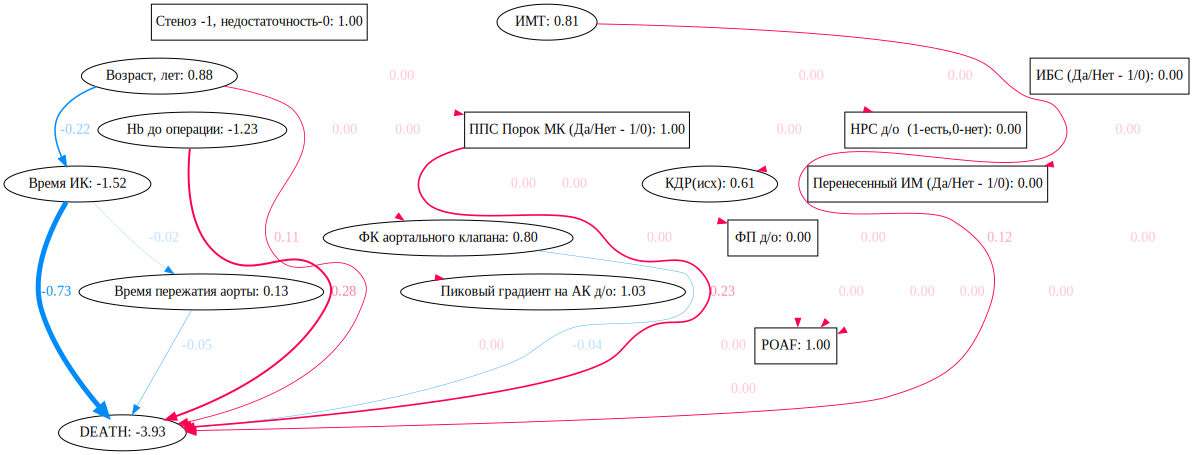

In [6]:
# Да-да, вот тут. Пациенты 1,2,3. 

G = GraphExplainer(causal_graph, bg, nruns=100)
cf_flow_adult = G.shap_values(fg)
cf_flow_adult.draw(1,
                   max_display=len(PREDICTORS),
                   #edge_credit=edge_credits2edge_credit(edge_credits, cf_flow_adult.graph),
                   show_fg_val=True, save_fpath='tmp.png')


In [8]:
shap_explainer = shap.TreeExplainer(model)
shap_values = shap_explainer.shap_values(xgb_test)
shap.initjs()

In [27]:
shap.force_plot(shap_explainer.expected_value, shap_values[1,:], X_test.iloc[1,:])

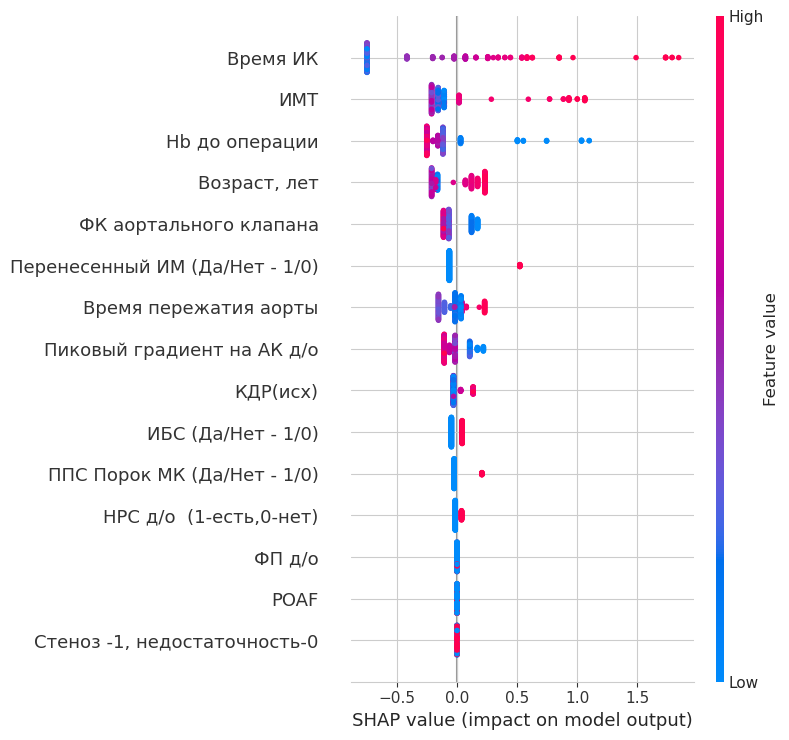

In [9]:
shap.summary_plot(shap_values,
                  X_test,
                  #plot_type='violin'
                  )

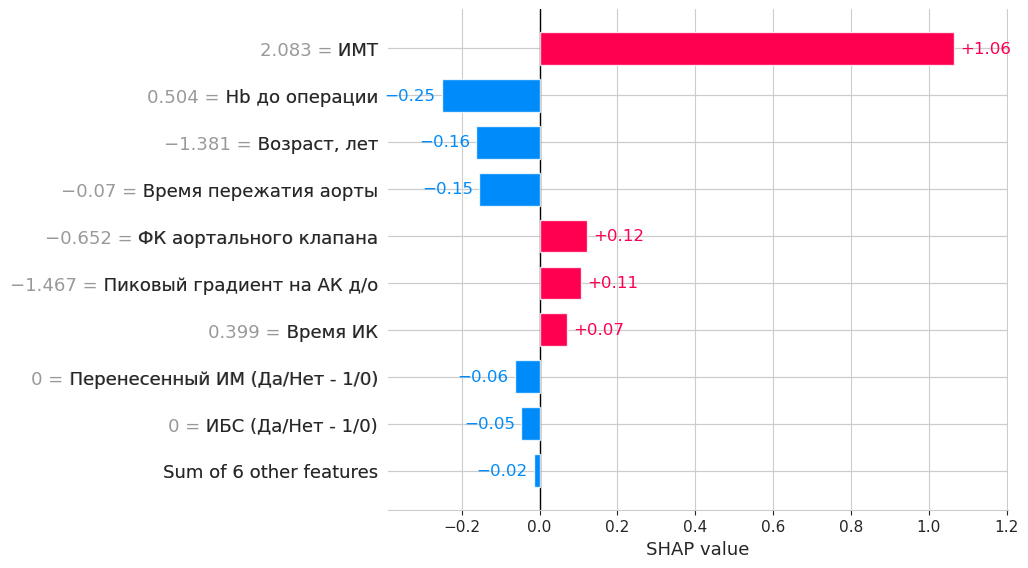

In [11]:
idx = 1
expl_obj = shap.Explanation(values=shap_values[idx],
                            base_values=shap_explainer.expected_value,
                            data=X_test.iloc[idx],
                            feature_names=X_test.columns.tolist())
shap.plots.bar(expl_obj)

In [71]:
X_test.iloc[0]

Время ИК                          0.158349
Hb до операции                    2.234130
ИМТ                              -1.813839
КДР(исх)                         -1.244234
ФК аортального клапана            0.216212
НРС д/о  (1-есть,0-нет)           0.000000
Пиковый градиент на АК д/о        1.027891
Стеноз -1, недостаточность-0      1.000000
Время пережатия аорты            -0.385694
POAF                              1.000000
ИБС (Да/Нет - 1/0)                0.000000
Возраст, лет                      0.569785
Перенесенный ИМ (Да/Нет - 1/0)    0.000000
ФП д/о                            0.000000
ППС Порок МК (Да/Нет - 1/0)       0.000000
Name: 487, dtype: float64